In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Solve a single mto once initiallly

In [2]:
from __future__ import print_function, absolute_import
import math
import matplotlib.pyplot as plt
import numpy as np

from multiple_traj_opt import (
    make_mto,
    MultipleTrajOpt,
    initial_conditions_Russ,
    initial_conditions_grid,
    initial_conditions_random,
)
from nn_system.networks import *
import torch

In [6]:
new_mto = make_mto()
new_mto.Solve()

RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

## Repeatedly run any of the cells below to do an iteration of each method!
Will switch out the values of old_mto and mto

In [4]:
# 0) RESTART WITH A DIFFERENT MINIBATCH OF INITIAL CONDITIONS
# Simplest possible version, (using the EXACT previous answer as a warm start)
def method0(mto, ic_list, **kwargs):
    old_mto = mto
    mto = make_mto(ic_list=ic_list, **kwargs) # Give the new ics here.

    # Warm start...
#     if old_mto is not None:
#         old_mto_dec_vals = old_mto.prog.GetSolution(old_mto.prog.decision_variables())
#         mto.prog.SetInitialGuessForAllVariables(old_mto_dec_vals)

    mto.Solve()
    return old_mto, mto
# old_mto, new_mto = method1(new_mto)

In [ ]:
# 1) SIMPLE RESTART WITH POTENTIALLY DIFFERENT SETTINGS, full huxT
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
def method1(mto):
    old_mto = mto
    mto = make_mto()

    # Warm start...
    old_mto_dec_vals = old_mto.prog.GetSolution(old_mto.prog.decision_variables())
    mto.prog.SetInitialGuessForAllVariables(old_mto_dec_vals)

    mto.Solve()
    return old_mto, mto
old_mto, new_mto = method1(new_mto)

In [ ]:
# 2) RESTART WITH A DIFFERENT MINIBATCH OF INITIAL CONDITIONS, use limited wallclock time policy rollouts?
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
def method2(mto):
    old_mto = mto
    old_mto_T_vals = old_mto.prog.GetSolution(old_mto.T)
    mto = make_mto()

    ic_list = #TODO
    assert len(ic_list) == num_trajectories
    for ic in ic_list:
        t_samples, x_samples, u_samples, logger = old_mto.__rollout_policy_at_solution(ti_or_ic=ic) # Be careful about this taking forever!!!!
        # Add a return for u_samples!!
        warm_start = #TODO: assemble a new batch of h, u, x?
        mto.prog.SetInitialGuess(mto.h[ti], ) #TODO
        mto.prog.SetInitialGuess(mto.u[ti], ) #TODO
        mto.prog.SetInitialGuess(mto.x[ti], ) #TODO
    mto.prog.SetInitialGuess(mto.T, old_mto_T_vals)
    mto.Solve()
    return old_mto, mto
old_mto, new_mto = method2(new_mto)

In [ ]:
# 3) RESTART WITH A DIFFERENT MINIBATCH OF INITIAL CONDITIONS, nearby traj. interpolations?
# Begs the question, will I want a history of trajectories??
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
# Keep a "BANK" of trajectories, that we can optionally use for warm starting?
# No consistency here!
if not trajectories:
    trajectories = []
def method3(mto, ic_list):
    global trajectories
    old_mto = mto

    for ti in range(num_trajectories):
        trajectory = np.hstack([old_mto.GetSolution(var) for var in (old_mto.h[ti], old_mto.u[ti], old_mto.x[ti])]) # (h, u_t's, x_t's)
        trajectories.append(trajectory)
    if len(trajectories) >mto = mto
    old_mto_T_vals = old_mto.prog.GetSolution(old_mto.T)
    mto = make_mto()

    warm_mto = MultipleTrajOpt("pendulum", 16, 16, 0.2, 0.5, ic_list=ic_list, warm_start=True, seed=old_mto.seed)
    warm_mto.add_nn_params(old_mto.kNetConstructor,
                      use_constraint    = False,
                      cost_factor       = 1.0,
                      initialize_params = True, 
                      reg_type          = old_mto.reg_type)
    warm_mto.add_cost_and_constraint_printing_callback(1)
    warm_mto.prog.SetInitialGuess(warm_mto.T, old_mto_T_vals) # "Warm start the warm start with the old network?"
    warm_mto.Solve()

    # Warm start paths with fresh solves, but carry over NN
    warm_mto_hux_vals = np.hstack([warm_mto.prog.GetSolution(var) for var in (warm_mto.h, warm_mto.u, warm_mto.x)])
    mto.prog.SetInitialGuessForAllVariables(np.hstack([warm_mto_hux_vals, old_mto_T_vals]))

    mto.Solve() CUTOFF:
        trajectories = trajectories[-CUTOFF:] # Keep bank trim and hopefully filter out the old crappy trajectories...
    mto = make_mto()

    # Warm start... but use a different warm start scheme
    ic_list = #TODO
    interpolants = []
    for ic in ic_list:
        # TODO, should have format of (h, u_t's, x_t's). Should be graded by ic and fc (and path?) proximity??
        # Can come from the previous solution, or the bank
        nearest = #TODO
        interpolants.append()
    assert len(interpolants) == len(ic_list)
    old_mto_dec_vals = old_mto.prog.GetSolution(old_mto.prog.decision_variables())
    mto.prog.SetInitialGuessForAllVariables(old_mto_dec_vals)

    mto.Solve()
    return old_mto, mto
old_mto, new_mto = method3(new_mto)

In [3]:
import copy
# 4) RESTART WITH A DIFFERENT MINIBATCH OF INITIAL CONDITIONS, fresh traj. solves? - should i split the traj solves?
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
def method4(mto, ic_list, **kwargs):
    old_mto = mto
    mto = make_mto(ic_list=ic_list, **kwargs)

#     warm_mto = MultipleTrajOpt("pendulum", 16, 16, 0.2, 0.5, ic_list=ic_list, warm_start=True, seed=old_mto.seed)
#     warm_mto.add_cost_and_constraint_printing_callback(1)
    print("\n\n BEGIN WARM START")
    warm_kwargs = copy.deepcopy(kwargs)
    warm_kwargs["kNetConstructor"] = None # Turn off NN, just for warm start
    warm_kwargs["vis_cb_every_nth"] = None
    warm_kwargs["cost_cb_every_nth"] = None
#     warm_kwargs["snopt_overrides"] = [('Major iterations limit',  1e9)]
    warm_mto = make_mto(ic_list=ic_list, **warm_kwargs)
    warm_mto.Solve()
    print("END WARM START \n\n")

    # Warm start paths with fresh solves, but carry over NN
    warm_mto_hux_vals = warm_mto.prog.GetSolution(warm_mto.prog.decision_variables())           # np.hstack([warm_mto.prog.GetSolution(var) for var in (warm_mto.h, warm_mto.u, warm_mto.x)])
    if old_mto is not None:
        old_mto_T_vals = old_mto.prog.GetSolution(old_mto.T)
    else:
        old_mto_T_vals = mto.prog.GetInitialGuess(mto.T)
    mto.prog.SetInitialGuessForAllVariables(np.hstack([warm_mto_hux_vals, old_mto_T_vals]))
        
    print("\n\n BEGIN REAL SOLVE")
    mto.Solve()
    print("END REAL SOLVE \n\n")
    return old_mto, mto
# old_mto, new_mto = method4(new_mto)

In [ ]:
# 5) RESTART WITH A DIFFERENT MINIBATCH OF INITIAL CONDITIONS, fresh traj. solves with policy violation cost?
# Is this even cheaper?
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
def method5(mto, ic_list):
    old_mto = mto
    old_mto_T_vals = old_mto.prog.GetSolution(old_mto.T)
    mto = make_mto()

    warm_mto = MultipleTrajOpt("pendulum", 16, 16, 0.2, 0.5, ic_list=ic_list, warm_start=True, seed=old_mto.seed)
    warm_mto.add_nn_params(old_mto.kNetConstructor,
                      use_constraint    = False,
                      cost_factor       = 1.0,
                      initialize_params = True, 
                      reg_type          = old_mto.reg_type)
    warm_mto.add_cost_and_constraint_printing_callback(1)
    warm_mto.prog.SetInitialGuess(warm_mto.T, old_mto_T_vals) # "Warm start the warm start with the old network?"
    warm_mto.Solve()

    # Warm start paths with fresh solves, but carry over NN
    warm_mto_hux_vals = np.hstack([warm_mto.prog.GetSolution(var) for var in (warm_mto.h, warm_mto.u, warm_mto.x)])
    mto.prog.SetInitialGuessForAllVariables(np.hstack([warm_mto_hux_vals, old_mto_T_vals]))

    mto.Solve()
    return old_mto, mto
old_mto, new_mto = method5(new_mto)

In [ ]:
# 6) EXPERIMENT WITH CARRYING OVER MORE THAN DECISION VARIABLE INITIAL GUESSES!!!!
# THIS WILL BE THE HARDEST EXPERIMENT... IT WILL REQUIRE RECOMPILING A NEW VERSION OF DRAKE????
# <TODO>
# https://github.com/RobotLocomotion/drake/blob/7c513516620b1e6001fd487e076c39f716027a79/solvers/snopt_solver.cc#L682

# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
def method6(mto, ic_list):
    old_mto = mto
    mto = make_mto()

    # Warm start... but use a different warm start scheme
    old_mto_dec_vals = old_mto.prog.GetSolution(old_mto.prog.decision_variables())
    mto.prog.SetInitialGuessForAllVariables(old_mto_dec_vals)

    mto.Solve()
    return old_mto, mto
old_mto, new_mto = method6(new_mto)

## Applying the warm starting methods to a full iterative optimization process below

In [10]:
def test_inner(string, secret=None):
    if secret is not None:
        print("got the secret")
    else:
        print(string)
def test_outer(string, **kwargs):
    test_inner(string, **kwargs)
test_outer("nope", secret="open sesame")

got the secret


iniitalizing params
Overrode Time limit (secs) = 600.0


 BEGIN WARM START
Overrode Time limit (secs) = 600.0
RESULT: SolutionResult.kSolutionFound TOTAL ELAPSED TIME: 2.13062810898
END WARM START 




 BEGIN REAL SOLVE
 0

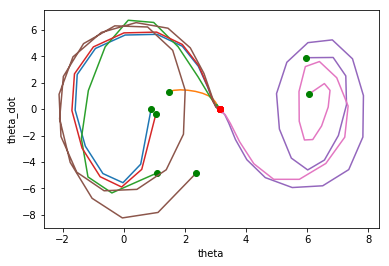

total cost:  3178.59 + ( 49557.14) | 	constraint  111.59 	bad 0,  0.00 + ( 0.00)
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50

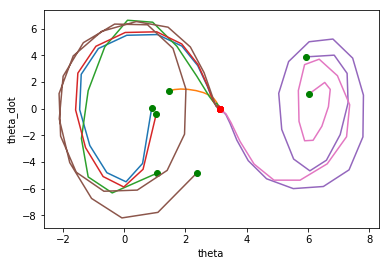

total cost:  3191.87 + ( 513.81) | 	constraint  113.65 	bad 0,  0.00 + ( 0.00)
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

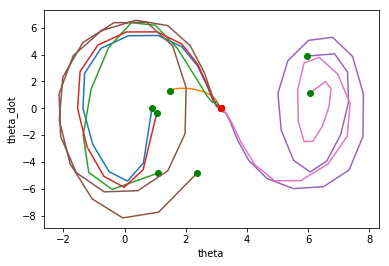

total cost:  3211.89 + ( 243.63) | 	constraint  114.26 	bad 0,  0.00 + ( 0.00)
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117

KeyboardInterrupt: 

In [17]:
##### RUSS'S MINIBATCH METHOD
%matplotlib inline
from torch.nn.init import * # Here's where I can specify which Torch NN inits I want...
from traj.vi_utils import (
    save_policy, 
    load_policy,
    plot_and_print_statistics,
    vis_vi_policy,
    vis_nn_policy_like_vi_policy
)

new_mto = None
seed = 1776; np.random.seed(seed); torch.manual_seed(seed)

use_dropout = True
nn_init     = kaiming_uniform_ # Will this even do anything with warm starting?
nn_noise    = 1e-2
class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=32, nn_init=None, nn_noise=0., use_dropout=False):
        self.nn_noise = nn_noise
        self.use_dropout = use_dropout
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc1 = nn.Linear(self.n_inputs, h_sz)
        self.fc2 = nn.Linear(h_sz, 1)
        
        if use_dropout:
            self.dropout = nn.Dropout(0.5) 
        
        if nn_init is not None:
#             for param in self.parameters():
#                 nn_init(param)
            nn_init(self.fc1.weight)
#             nn_init(self.fc1.bias)
            nn_init(self.fc2.weight)
#             nn_init(self.fc2.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        x += self.nn_noise # Will this work in Torch?
        return x
    
# Move to vi_utils?
def eval_vi_policy(x, vi_policy):
    mesh = vi_policy.get_mesh()
    ovs  = vi_policy.get_output_values()
    return mesh.Eval(ovs, x)
def eval_nn_policy(x, net):
    return net.forward(torch.tensor(x)).data.numpy()
    
# Minibatch optimization...
total_iterations = 10
# method = method0
method = method4
vi_policy, _ = load_policy("good", "pendulum")
while total_iterations > 0:
    total_iterations -= 1
    num_trajectories = 7
    ic_list = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5, 5))
    old_mto, new_mto = method(new_mto, 
                              ic_list, 
                              num_trajectories=num_trajectories,
                              expmt = "pendulum",
                              kNetConstructor=lambda: FCBIG(n_inputs=2, nn_init=nn_init),
                              use_constraint=False,
                              cost_factor=25.,
                              vis_cb_every_nth=50, 
                              cost_cb_every_nth=50, 
                              seed=None,
                              snopt_overrides=[('Time limit (secs)',  600.0)])
    # Print learned policy vs vi_policy here (only possible for state dim == 2)
    net = new_mto.create_net()
    net.eval()
    if new_mto.expmt == "pendulum":
        vis_vi_policy(vi_policy)
        vis_nn_policy_like_vi_policy(net, vi_policy)

    # Print Divergence metrics between the two policies
    results = []
    if new_mto.expmt == "pendulum":
        test_coords = initial_conditions_random(num_trajectories, (0, 2*math.pi), (-5/2, 5/2))
    elif new_mto.expmt == "cartpole":
        test_coords = initial_conditions_random_all_dims(num_trajectories, ((-3., 3.), (0., 2*math.pi), (-1., 1.), (-1., 1.)) )
    test_coords = ic_list
    for coord in test_coords:
        pair = (eval_vi_policy(coord, vi_policy), eval_nn_policy(coord, net))
        results.append(pair)
    diffs = [result[1] - result[0] for result in results]
    plot_and_print_statistics(diffs, "nn - vi policy deviations", bins=100, xlim=None)
        
        

In [ ]:
##### IGOR'S BLOCK-ALTERNATING METHOD - THIS IS BEING WORKED ON IN ANOTHER NOTEBOOK!!!!!
# Init work here...
# <TODO>

# Minibatch optimization... Let's not do any warm starting for Igor's...
total_iterations = 10
while total_iterations >= 0:
    total_iterations -= 1
    ic_list = #TODO
    igor_traj_opt()
    igor_supervised_learning()
    visualize_intermediate_results()

## ----------------------------------------- Visualizations below this line --------------------------------------

In [ ]:
#### Get a sense of the consistency of x and u!
# Let's plot all the u's on the z axis and x (theta, theta_dot) on the y and x axes...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for ti in range(new_mto.num_trajectories):
    h_sol  = new_mto.prog.GetSolution(new_mto.h[ti])[0]
    print(h_sol)

    t_s = [h_sol*i for i in range(new_mto.num_samples)]
    x_s  = new_mto.prog.GetSolution(new_mto.x[ti])
    u_s    = new_mto.prog.GetSolution(new_mto.u[ti])
    x_trajectory = PiecewisePolynomial.Cubic(t_s, x_s, False)
#     t_samples = np.linspace(breaks[0], breaks[-1], 100) 
#     x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    thetas, theta_dots = zip(*x_s)
    print(thetas, theta_dots, u_s)
    xs += thetas
    ys += theta_dots
    zs += u_s
print(list((len(thing) for thing in (xs, ys, zs))))
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


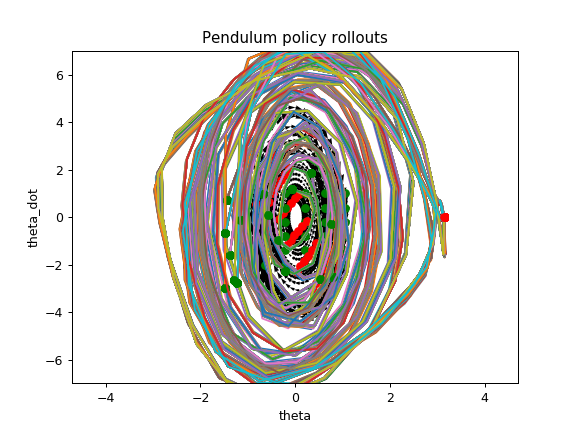

In [28]:
import math
ic_list = initial_conditions_grid(36, (-math.pi/3, math.pi/3), (-5/3, 5/3))
new_mto.plot_all_policies("state_quiver", ic_list)

In [ ]:
from nn_system.NNSystemHelper import create_nn
kNetConstructor = lambda: FCBIG(2)
nn = create_nn(kNetConstructor, list(new_mto.prog.GetSolution(new_mto.T)))
list(nn.parameters())

In [ ]:
ti = 0
mto.render_policy(ti)

<IPython.core.display.Javascript object>


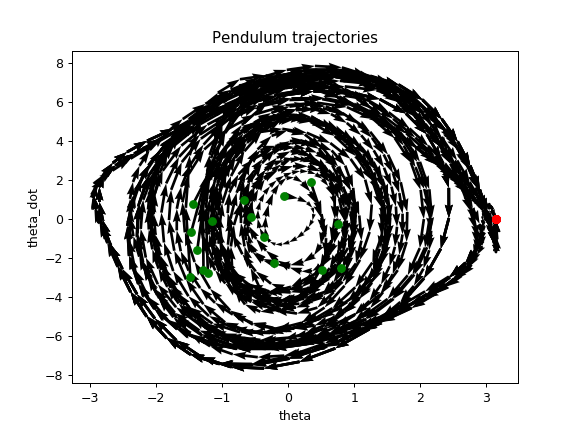

In [27]:
# mto.plot_all_trajectories("state_scatter")
new_mto.plot_all_trajectories("state_quiver")
# mto.plot_all_trajectories("tip_scatter")
# mto.plot_all_trajectories("tip_quiver")

### Visualize the found trajectories

In [ ]:
ti = 0
mto.plot_single_trajectory(ti, "state_scatter")
mto.plot_single_trajectory(ti, "state_quiver")
mto.plot_single_trajectory(ti, "tip_scatter")
mto.plot_single_trajectory(ti, "tip_quiver")

mto.render_single_trajectory(ti)